Style Transfering using PyTorch.

Based on https://pytorch.org/tutorials/advanced/neural_style_tutorial.html.

In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load images

In [3]:
img_size = 512

def image_loader(image_path, img_size_hw = None):
    loader = transforms.Compose([
        transforms.Resize(img_size_hw if img_size_hw else img_size),
        transforms.ToTensor()
    ])

    image = Image.open(image_path)
    image = loader(image).unsqueeze(0)
    return image.to(device)

content_img = image_loader('./images/content_1.jpg')
# resize style image to content image size
style_img = image_loader('./images/style_1.jpg', tuple(content_img.shape[-2:]))

In [4]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

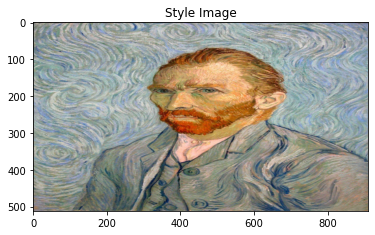

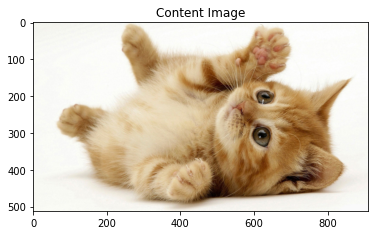

In [5]:
imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')

# Loss

In [6]:
def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)


class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# Model

In [7]:
cnn_model = models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1').features.to(device).eval()

In [8]:
cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]

class CNNNormalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = torch.tensor(mean).to(device).view(-1, 1, 1)
        self.std = torch.tensor(std).to(device).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [9]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def model_with_losses(cnn_model, normalization_mean, normalization_std, style_img, content_img, 
                      content_layers=content_layers_default, style_layers=style_layers_default):
    norm = CNNNormalization(normalization_mean, normalization_std)
    content_losses = []
    style_losses = []

    model = nn.Sequential(norm)
    i = 0
    for layer in cnn_model.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
        
    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [10]:
def transfer_style(cnn_model, max_epochs, normalization_mean, normalization_std, content_img, style_img, input_img, 
                   style_weight=1000000, content_weight=1, **optimizer_kwargs):

    model, style_losses, content_losses = model_with_losses(cnn_model, normalization_mean, normalization_std, style_img, content_img)

    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = optim.LBFGS([input_img], **optimizer_kwargs)

    run = [0]
    scores = [[0]]
    best_score = [(-1, 10000)]
    best_img = [input_img]
    while run[0] < max_epochs:
        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            scores[0].append(loss.item())
            if 0 < scores[0][-1] < best_score[0][1]:
                best_score[0] = (run[0], scores[0][-1])
                best_img[0] = input_img.clone().detach()

            if run[0] % 100 == 0:
                print(f'{run[0]} / {max_epochs}')
                print(f'Style Loss : {style_score:.4f} Content Loss: {content_score:.4f}. Best score: {best_score[0][1]:.4f}, iter {best_score[0][0]}')
                imshow(input_img, title='Mid Result Image')

            return style_score + content_score
        
        optimizer.step(closure)
        if math.isnan(scores[0][-1]) or scores[0][-1] / scores[0][-2] > 10:
            break

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img, best_img[0], scores[0]

# Test results

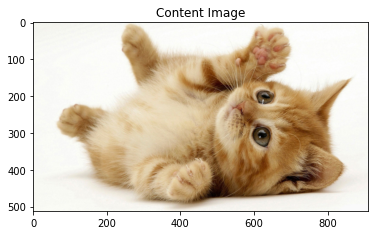

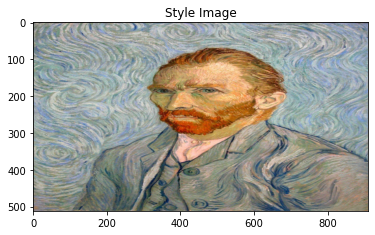

In [12]:
content_img = image_loader('./images/content_1.jpg')
style_img = image_loader('./images/style_1.jpg', list(content_img.shape[-2:]))
imshow(content_img, title='Content Image')
imshow(style_img, title='Style Image')

There were a lot of tries with different hyperparameters and different losses on different images. Here is the example with good parameters for many attempts.

100 / 800
Style Loss : 1.2066 Content Loss: 0.1154. Best score: 1.3220, iter 100


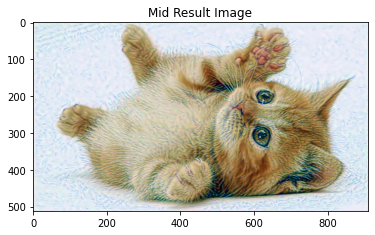

200 / 800
Style Loss : 0.1347 Content Loss: 0.1219. Best score: 0.2566, iter 200


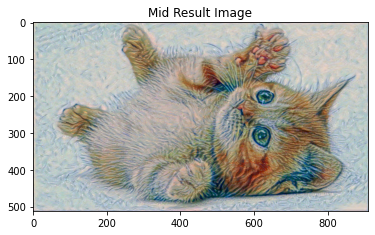

300 / 800
Style Loss : 0.0254 Content Loss: 0.1031. Best score: 0.1285, iter 300


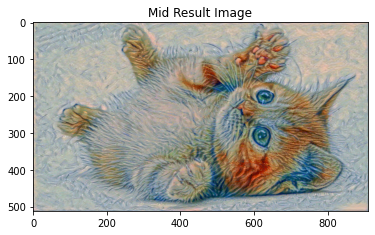

400 / 800
Style Loss : 0.0103 Content Loss: 0.0874. Best score: 0.0977, iter 400


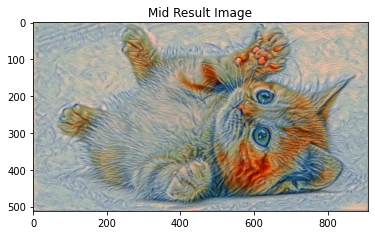

500 / 800
Style Loss : 0.0069 Content Loss: 0.0793. Best score: 0.0862, iter 500


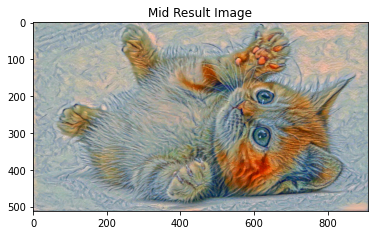

600 / 800
Style Loss : 0.0053 Content Loss: 0.0751. Best score: 0.0805, iter 600


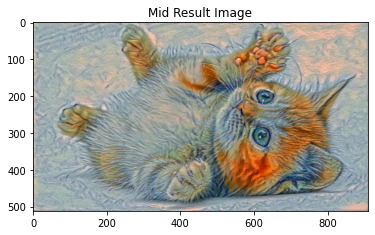

700 / 800
Style Loss : 0.0044 Content Loss: 0.0727. Best score: 0.0771, iter 700


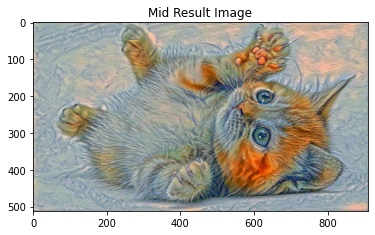

800 / 800
Style Loss : 0.0039 Content Loss: 0.0710. Best score: 0.0749, iter 800


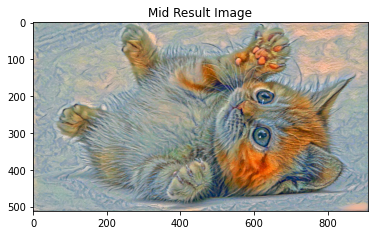

In [13]:
input_img = content_img.clone()
# input_img = torch.randn(content_img.data.size(), device=device)

output, best_img, scores = transfer_style(cnn_model, 800, cnn_normalization_mean, cnn_normalization_std,
                                          content_img, style_img, input_img,
                                          style_weight=10000, content_weight=0.01,
                                          lr=0.1)

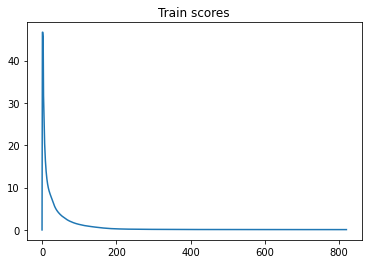

In [16]:
plt.plot(scores)
_ = plt.title('Train scores')

Examples (parameters: max_epochs=800, style_weight=10000, content_weight=0.01, lr=0.1)

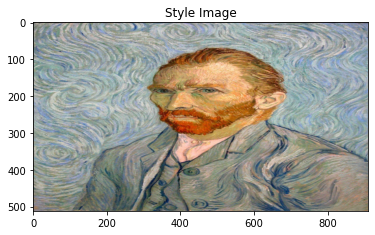

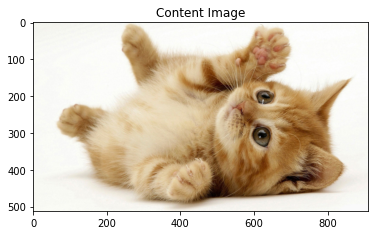

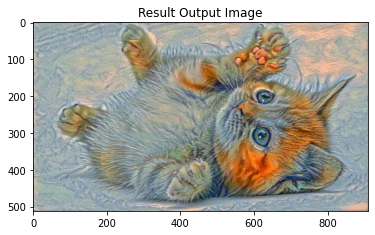

In [26]:
imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')
imshow(best_img, title='Result Output Image')

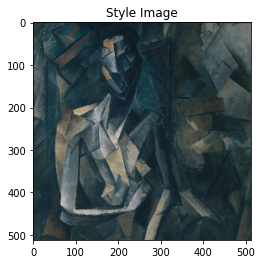

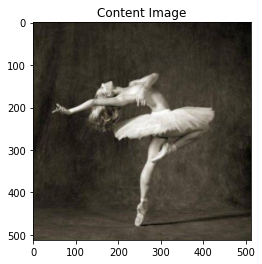

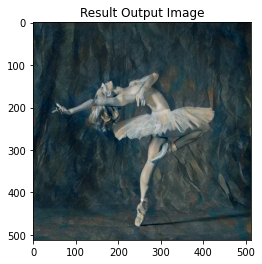

In [29]:
imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')
imshow(best_img, title='Result Output Image')

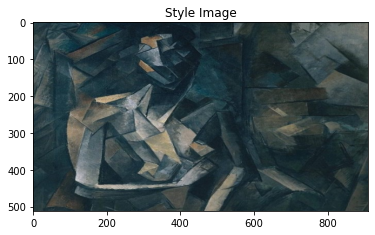

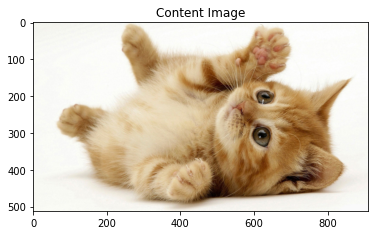

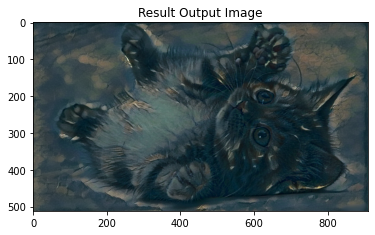

In [38]:
imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')
imshow(best_img, title='Result Output Image')

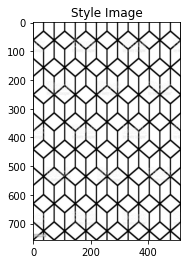

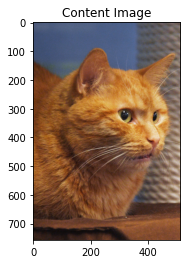

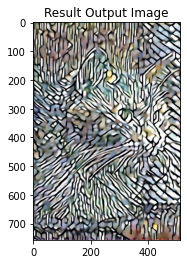

In [32]:
imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')
imshow(best_img, title='Result Output Image')